# Exercises - GEO4902-02 - Data Assimilation

[Save google-collab as jupyter notebook, html, or md with your name in the filename, and upload on canvas]

## Exercise 1 - Analyse the impact of “upper-air” data assimilation in forecasts

In [1]:
# import packages
import xarray as xr
import math
import numpy as np
import cartopy as cy
from matplotlib import pyplot as plt
from cmcrameri import cm


The script gives you a framework to assess two different forecasts, initialized on the same day but for different times of the day. Note, forecasts are available with initialization dates every 3 hours, i.e., we assimilate every three hours (rapid update cycling), but we do full forecasts only every 6 hours.


***Fill in the dates and hours for the exercise***


In [2]:
year =  '2022'
day  =  '05'
month = '10'

hour_1  ='00'
hour_2  ='03'

url='https://thredds.met.no/thredds/dodsC/aromearcticarchive/'+year+'/'+month+'/'+day+'/arome_arctic_det_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_1 = xr.open_dataset(url)
print(forecast_1)

url='https://thredds.met.no/thredds/dodsC/aromearcticarchive/'+year+'/'+month+'/'+day+'/arome_arctic_det_2_5km_'+year+month+day+'T'+hour_2+'Z.nc'
forecast_2 = xr.open_dataset(url)
#print(forecast_2.data_vars)

<xarray.Dataset>
Dimensions:                                                                      (
                                                                                  time: 67,
                                                                                  mean_sea_level: 1,
                                                                                  surface: 1,
                                                                                  pressure: 13,
                                                                                  height_above_msl: 1,
                                                                                  ...
                                                                                  adiabatic_condensation_level: 1,
                                                                                  maximum_wind_level: 1,
                                                                                  tropopause: 1,
           

**Find a specific point and plot the forecast.**

>Note AROME MetCoOp is on an irregular grid, so the xarray.sel functionality does not work. But it does work for the ECMWF IFS grid (see below)


In [3]:
# Define a function to find the closest grid point to a given location. Once the function is defined one does not need to copy 
# the lines necessary to find the closest grid point in the dataset.

def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslat,abslon)
    y, x = np.where(c == np.min(c))
    
    y=int(y)
    x=int(x)
   
    return (y,x)

In [4]:
# I want to find the 2m-temperature at a certain lat/lon point.
# Tromsø
lat_tos = 69.6537
lon_tos = 18.9368

# find the x and y coordinates
[y_tos,x_tos] = findindex(forecast_1['latitude'],
                          forecast_1['longitude'],
                          lat_tos,lon_tos) # For Tromsø



/tmp/ipykernel_11807/3902046065.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)
/tmp/ipykernel_11807/3902046065.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)


In [5]:
# check if we selected the lat and lot for Tromsø
print('Tromsø AROME: latitude: {}, longitude: {}'.format((forecast_1['latitude'].isel(y = y_tos, x = x_tos).values).round(2,), (forecast_1['longitude'].isel(y = y_tos, x = x_tos).values).round(2,)))

Tromsø AROME: latitude: 69.66, longitude: 18.93


**For example temperature, specific humidity, and wind speed forecasts at a specific model level**

1. Utilize the script to plot the impact on point forecasts. That means plot 2 or more forecasts with different initialization times in one figure. Use also at least 2 additional variables relevant for a weather forecast.



In [6]:
mlevel=64

# Air temperature
tml_point_forecast_1 = forecast_1.air_temperature_ml.isel(hybrid = mlevel, y = y_tos, x = x_tos)
tml_point_forecast_2 = forecast_2.air_temperature_ml.isel(hybrid = mlevel, y = y_tos, x = x_tos)

# specific humidity
sh_point_forecast_1 = forecast_1.specific_humidity_ml.isel(hybrid = mlevel, y = y_tos, x = x_tos)
sh_point_forecast_2 = forecast_2.specific_humidity_ml.isel(hybrid = mlevel, y = y_tos, x = x_tos)

In [7]:


# calculate wind direction and speed from x and y
def calc_wind_dir_speed(xwind, ywind):
  
  # wind direction
  wind_dir  = np.arctan2(ywind , xwind)    # wind is now in Pi
  wind_dir  = (270 - np.rad2deg(wind_dir ))     # wind is now in deg
  # adjust if values larger 360
  _larger360 = np.where(wind_dir[:,] > 360.)
  _larger360 = np.array(_larger360).flatten()
  wind_dir[_larger360] = wind_dir[_larger360] - 360.


  # wind speed
  wind_speed = np.sqrt(xwind**2 + ywind**2)

  return(wind_dir, wind_speed)

In [8]:
# Wind direction, Wind speed
wd_point_forecast_1, ws_point_forecast_1 = calc_wind_dir_speed(forecast_1.x_wind_ml.isel(hybrid = mlevel, y = y_tos, x = x_tos), forecast_1.y_wind_ml.isel(hybrid = mlevel, y = y_tos, x = x_tos))
wd_point_forecast_2, ws_point_forecast_2 = calc_wind_dir_speed(forecast_2.x_wind_ml.isel(hybrid = mlevel, y = y_tos, x = x_tos), forecast_2.y_wind_ml.isel(hybrid = mlevel, y = y_tos, x = x_tos))

In [9]:
def plt_temp_sh_wind(axsm, forecast_1, forecast_2, 
                       tml_point_forecast_1, tml_point_forecast_2,
                       sh_point_forecast_1, sh_point_forecast_2,
                       ws_point_forecast_1, ws_point_forecast_2,
                       wd_point_forecast_1, wd_point_forecast_2,
                       ):
  axs = axsm.flatten()

  # air temperature in model level
  (tml_point_forecast_1-273.15).plot(ax = axs[0], linestyle = '-.', label = np.datetime_as_string(forecast_1.time[0],unit='h'))
  (tml_point_forecast_2-273.15).plot(ax = axs[0], linestyle = '-', label = np.datetime_as_string(forecast_2.time[0],unit='h'))

  axs[0].legend(loc = "upper left")
  axs[0].set_ylabel('Air temperature [C]')

  # specific humidity
  (sh_point_forecast_1).plot(ax = axs[1], linestyle = '-.',)
  (sh_point_forecast_2).plot(ax = axs[1], linestyle = '-')
  axs[1].set_ylabel('Specific humidity [kg/kg]')

  # Wind speed
  ws_point_forecast_1.plot(ax = axs[2], linestyle = '-.')
  ws_point_forecast_2.plot(ax = axs[2], linestyle = '-') 
  axs[2].set_ylabel('Wind speed [ms-1]')

  # Wind direction
  wd_point_forecast_1.plot(ax = axs[3], linestyle = '-.')
  wd_point_forecast_2.plot(ax = axs[3], linestyle = '-')
  axs[3].set_ylabel('Wind direction $^{o}$')

  plt.tight_layout()

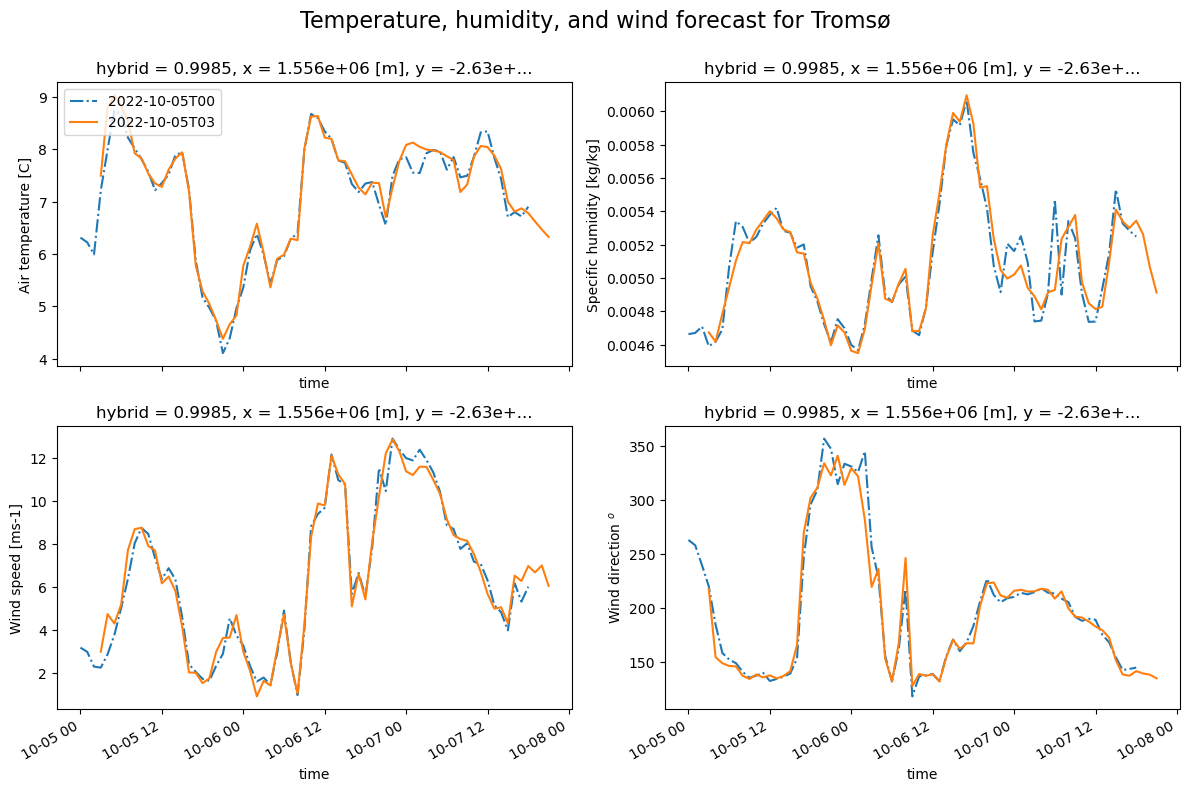

In [10]:
# Plot the point forecast
fig, axsm = plt.subplots(2,2, 
                         figsize=[12,7.5], 
                         sharex=True
                         )
plt_temp_sh_wind(axsm, forecast_1, forecast_2, 
                       tml_point_forecast_1, tml_point_forecast_2,
                       sh_point_forecast_1, sh_point_forecast_2,
                       ws_point_forecast_1, ws_point_forecast_2,
                       wd_point_forecast_1, wd_point_forecast_2,
                       )
fig.suptitle('Temperature, humidity, and wind forecast for Tromsø', fontsize=16, y = 1.05);

**Plot forecast on a map**

1. Utilize the script to plot a 2D map of the impact of the data assimilation. This means the difference between the background xB and the analysis xA. To find the background, think about what goes into the data assimilation procedure from the previous forecast? Plot maps for the different variables in (1) and different levels.

background xB is initalised at 00UTC but at time=03

analysis xA is initialised at 03UTC but at time=0

-> impact of the data assimilation process = xB - xA


In [11]:
forecast_1.hybrid  # hybrid levels are 1 at the surface and 0 at the top of the model 

<xarray.DataArray 'hybrid' (hybrid: 65)>
array([0.009869, 0.029609, 0.049358, 0.069134, 0.088964, 0.108876, 0.128901,
       0.149073, 0.169427, 0.189999, 0.210865, 0.232107, 0.253729, 0.275688,
       0.297939, 0.320439, 0.343144, 0.366009, 0.388991, 0.412046, 0.43513 ,
       0.458198, 0.481207, 0.504113, 0.526872, 0.54944 , 0.571772, 0.593825,
       0.615555, 0.636918, 0.65787 , 0.678367, 0.698365, 0.717819, 0.736687,
       0.754923, 0.772484, 0.789327, 0.805406, 0.820678, 0.8351  , 0.848655,
       0.86138 , 0.873322, 0.884509, 0.894971, 0.904738, 0.91384 , 0.922307,
       0.930172, 0.937464, 0.944216, 0.950461, 0.95623 , 0.961557, 0.966477,
       0.971023, 0.975233, 0.979141, 0.982786, 0.986208, 0.989446, 0.992545,
       0.995552, 0.99852 ])
Coordinates:
  * hybrid   (hybrid) float64 0.009869 0.02961 0.04936 ... 0.9925 0.9956 0.9985
Attributes:
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula:        p(n,k,j,i) = ap(k) + b(k)*ps(n,j,i)
    formula_terms:  ap: ap b: b ps: surface_air_pressure p0: p0
    long_name:      atmosphere_hybrid_sigma_pressure_coordinate
    positive:       down
    _ChunkSizes:    65

In [12]:
timestep_1 = 3
mlevel=64

diff_temperature_ml = (forecast_1.air_temperature_ml.isel(time = timestep_1, hybrid = mlevel))  - (forecast_2.air_temperature_ml.isel(time = 0, hybrid = mlevel)) 
diff_specific_humidity_ml = (forecast_1.specific_humidity_ml.isel(time = timestep_1, hybrid = mlevel)) - (forecast_2.specific_humidity_ml.isel(time = 0, hybrid = mlevel))

ws_forecast_1_ml = np.sqrt(forecast_1.x_wind_ml.isel(time = timestep_1, hybrid = mlevel)**2 + forecast_1.y_wind_ml.isel(time = timestep_1, hybrid = mlevel)**2)
ws_forecast_2_ml = np.sqrt(forecast_2.x_wind_ml.isel(time = 0, hybrid = mlevel)**2 + forecast_2.y_wind_ml.isel(time = 0, hybrid = mlevel)**2)

diff_ws_ml = (ws_forecast_1_ml) - (ws_forecast_2_ml)

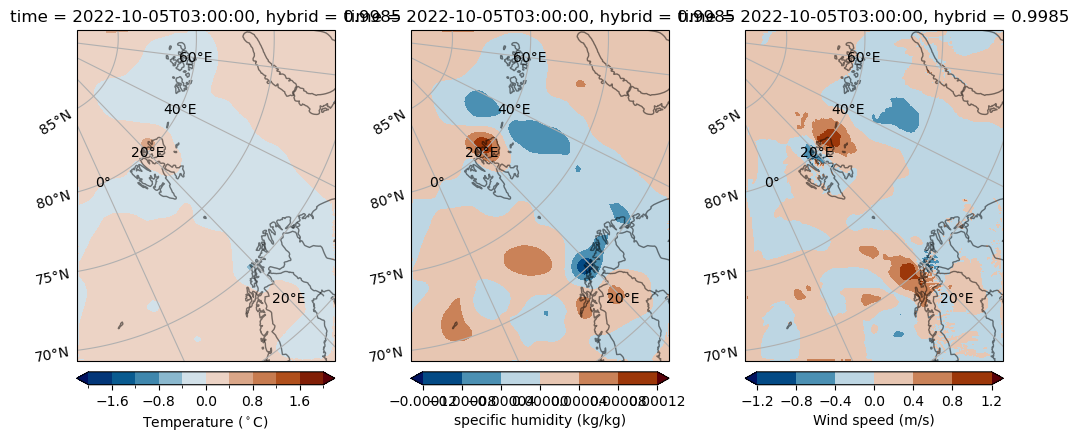

In [13]:
projection = cy.crs.LambertConformal(central_longitude =forecast_1.projection_lambert.longitude_of_central_meridian,
                                       central_latitude  =forecast_1.projection_lambert.latitude_of_projection_origin,
                                       standard_parallels = forecast_1.projection_lambert.standard_parallel)

f, axsm = plt.subplots(1,3, subplot_kw={'projection':projection}, figsize=[10, 7.2])

for ax in axsm.flatten():
    # plot cosmetics
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False


diff_temperature_ml.plot.contourf(ax=axsm[0], 
                                 x='longitude', 
                                 y='latitude', 
                                 cmap=cm.vik, 
                                 extend='both', 
                                 transform=cy.crs.PlateCarree(),
                                 levels=np.arange(-2,2.4,0.4),
                                 cbar_kwargs={'orientation':'horizontal','label':'Temperature ($^\circ$C)', 'shrink':1., 'pad':0.015})

diff_specific_humidity_ml.plot.contourf(ax=axsm[1], 
                                        x='longitude',
                                        y='latitude',
                                        cmap=cm.vik,
                                        extend='both',
                                        transform=cy.crs.PlateCarree(),
                                        levels=np.arange(-0.00012, 0.00016, 0.00004),
                                        cbar_kwargs={'orientation':'horizontal','label':'specific humidity (kg/kg)', 'shrink':1., 'pad':0.015}
                                        )

diff_ws_ml.plot.contourf(ax=axsm[2], 
                         x='longitude', 
                         y='latitude',
                         cmap=cm.vik,
                         extend='both',
                         transform=cy.crs.PlateCarree(),
                         levels=np.arange(-1.2,1.6,0.4),
                         cbar_kwargs={'orientation':'horizontal','label':'Wind speed (m/s)', 'shrink':1., 'pad':0.015}
                        )

plt.tight_layout()

## Exercise 2 - Analyse the impact of the data assimilation - Surface Model

The script gives you a framework to assess two different forecasts, initialized on the same day but for different times of the day. It follows the same logic as Exercise 1 but this time for the (land-)surface model.


1. Utilize the script to plot the impact on point forecasts. That means plot 2 or more forecasts in one figure. Use also different variables.




In [14]:
mlevel=64

# Air temperature
tml_point_forecast_1_sfc = forecast_1['air_temperature_2m'].isel(y = y_tos, x = x_tos)
tml_point_forecast_2_sfc = forecast_2['air_temperature_2m'].isel(y = y_tos, x = x_tos)

# specific humidity
sh_point_forecast_1 = forecast_1['specific_humidity_2m'].isel(y = y_tos, x = x_tos)
sh_point_forecast_2 = forecast_2['specific_humidity_2m'].isel(y = y_tos, x = x_tos)

# Wind direction, Wind speed
wd_point_forecast_1_sfc, ws_point_forecast_1_sfc = calc_wind_dir_speed(forecast_1['x_wind_10m'].isel(y = y_tos, x = x_tos), forecast_1['y_wind_10m'].isel(y = y_tos, x = x_tos))
wd_point_forecast_2_sfc, ws_point_forecast_2_sfc = calc_wind_dir_speed(forecast_2['x_wind_10m'].isel(y = y_tos, x = x_tos), forecast_2['y_wind_10m'].isel(y = y_tos, x = x_tos))


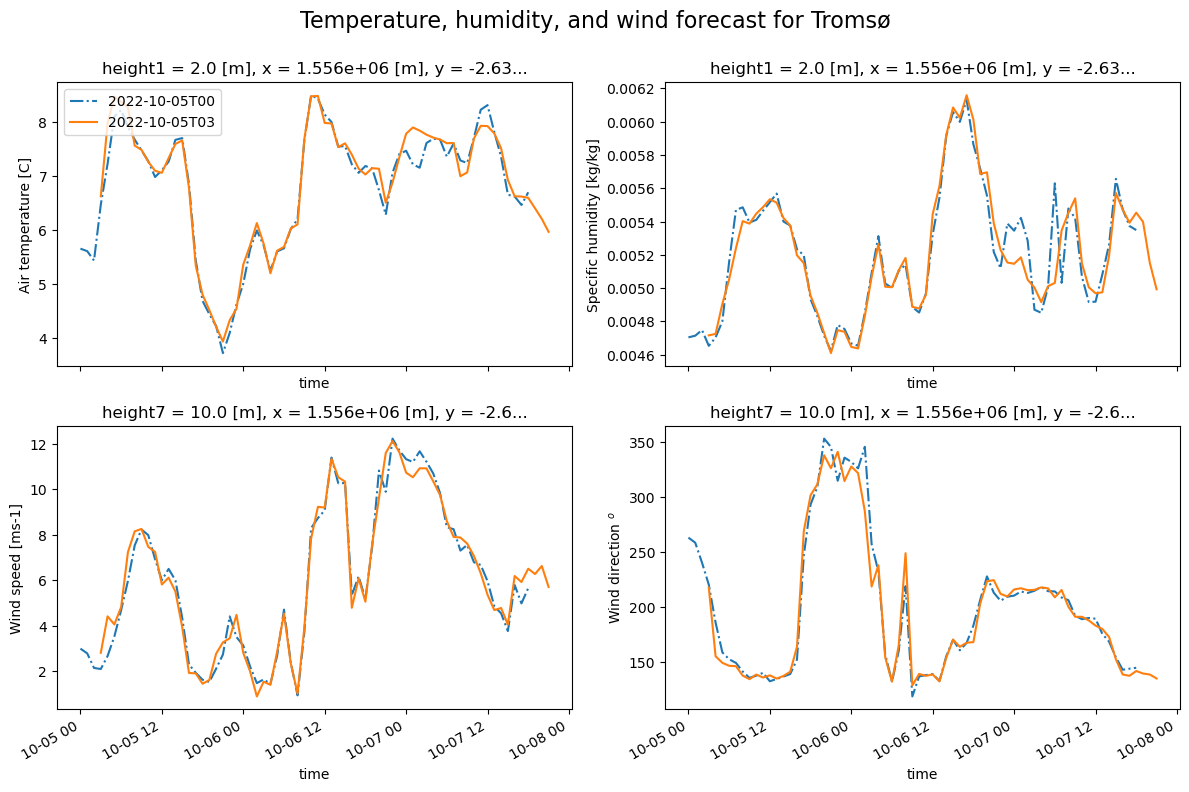

In [15]:
fig, axsm = plt.subplots(2,2, 
                         figsize=[12,7.5], 
                         sharex=True
                         )
plt_temp_sh_wind(axsm, forecast_1, forecast_2, 
                       tml_point_forecast_1_sfc, tml_point_forecast_2_sfc,
                       sh_point_forecast_1, sh_point_forecast_2,
                       ws_point_forecast_1_sfc, ws_point_forecast_2_sfc,
                       wd_point_forecast_1_sfc, wd_point_forecast_2_sfc,
                       )
fig.suptitle('Temperature, humidity, and wind forecast for Tromsø', fontsize=16, y = 1.05);

2. Utilize the script to plot a 2D map of the impact of the data assimilation. This means the difference between the background xB and the analysis xA. To find the background think about what goes into the data assimilation procedure from the previous forecast? Plot maps for different variables (levels are all surface (“screen”) levels).

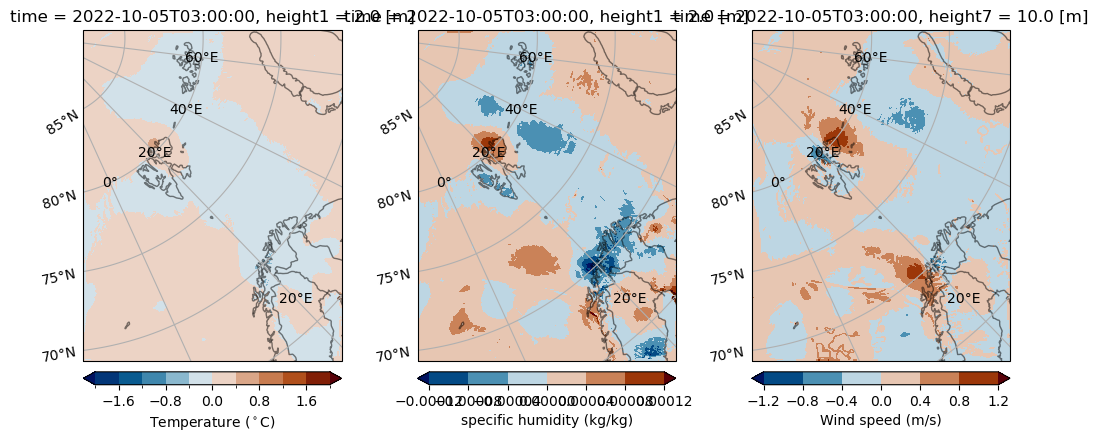

In [16]:
diff_temperature_sfc = (forecast_1['air_temperature_2m'].isel(time = timestep_1,height1=0)) - (forecast_2['air_temperature_2m'].isel(time = 0,height1=0))
diff_specific_humidity_sfc = (forecast_1['specific_humidity_2m'].isel(time = timestep_1,height1=0)) - (forecast_2['specific_humidity_2m'].isel(time = 0,height1=0))


ws_forecast_1_sfc = np.sqrt(forecast_1['x_wind_10m'].isel(time = timestep_1,height7=0)**2 + forecast_1['y_wind_10m'].isel(time = timestep_1,height7=0)**2)
ws_forecast_2_sfc = np.sqrt(forecast_2['x_wind_10m'].isel(time = 0,height7=0)**2 + forecast_2['y_wind_10m'].isel(time = 0,height7=0)**2)

diff_ws_sfc = (ws_forecast_1_sfc) - (ws_forecast_2_sfc)

# plot difference surface
f, axsm = plt.subplots(1,3, subplot_kw={'projection':projection}, figsize=[10, 7.2])

for ax in axsm.flatten():
    # plot cosmetics
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False


diff_temperature_sfc.plot.contourf(ax=axsm[0], 
                                 x='longitude', 
                                 y='latitude', 
                                 cmap=cm.vik, 
                                 extend='both', 
                                 transform=cy.crs.PlateCarree(),
                                 levels=np.arange(-2,2.4,0.4),
                                 cbar_kwargs={'orientation':'horizontal','label':'Temperature ($^\circ$C)', 'shrink':1., 'pad':0.015})

diff_specific_humidity_sfc.plot.contourf(ax=axsm[1], 
                                        x='longitude',
                                        y='latitude',
                                        cmap=cm.vik,
                                        extend='both',
                                        transform=cy.crs.PlateCarree(),
                                        levels=np.arange(-0.00012, 0.00016, 0.00004),
                                        cbar_kwargs={'orientation':'horizontal','label':'specific humidity (kg/kg)', 'shrink':1., 'pad':0.015}
                                        )

diff_ws_sfc.plot.contourf(ax=axsm[2], 
                         x='longitude', 
                         y='latitude',
                         cmap=cm.vik,
                         extend='both',
                         transform=cy.crs.PlateCarree(),
                         levels=np.arange(-1.2,1.6,0.4),
                         cbar_kwargs={'orientation':'horizontal','label':'Wind speed (m/s)', 'shrink':1., 'pad':0.015}
                        )

plt.tight_layout()


2. Describe and interpret the difference between the result in Exercise 1


* both, surface and upper air show the impact of the data assimilation
* difference is larger at surface for temperature
* taking lowest level from the full model (e.g. 64) does not give the same result
* more variation at surface levels than in upper air -> more ground observations than vertical obersations



## Exercise 3 - Data assimilation: Single observation experiment

For (a) testing new observations, (b) analyzing their impact, and (c) understanding the impact of the data assimilation system, we often perform so-called “single-observation experiments”. Only one single observation is included in the data assimilation system, and we can compare the background and the analysis. In the following example, a radiosonde temperature observation at 500 hPa height has been assimilated.

The background xB and analysis xA include the prognostic variables of temperature, wind, and specific humidity. The data files are for the Norwegian area and distributed in 60 vertical levels. The python script for this exercise gives you the access points to this data and two plotting routines to plot vertical sections and horizontal layers of the model data.

Load **BACKGROUND** fields of temperature,wind, and specific humidity.


In [17]:
url='https://thredds.met.no/thredds/dodsC/metusers/maltem/GEO4902_2020/remap.varn.BG.nc'
model_background = xr.open_dataset(url)

In [18]:
# rename the lev_2 coordinate to the same name as the analysis data
model_background = model_background.rename({'lev_2': 'lev',})


Load **ANALYSIS** fields of temperature,wind, and specific humidity.

This analysis has been produced by assimilating a radiosonde information at 500hPa


In [19]:
url='https://thredds.met.no/thredds/dodsC/metusers/maltem/GEO4902_2020/remap.varn.LPB_POS2_TEMP500.nc'
model_analysis = xr.open_dataset(url)

The data is stored in the original coordinates of the model, but do not worry about that. Just assume it is some kind of vertical discretization. Remember that you can look in the metadata to find the variable names and coordinate information!

1. Find out where the radiosonde was assimilated. (level and geographical location)

To find the level and geographical location, we can make use of the [argmax() function of xarray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.argmax.html). The argmax function will find the maximum of the DataArray over the dimensions given. The result can then be passed directly to isel(). But to get the idx of the maximum we first have to calculate the absolute values of the difference between background and analysis. We know where the radiosonde was assimilated from the largest difference between background and analysis (assimilation impact).


In [20]:
timestep=0; 
_t = model_background.air_temperature.isel(time = timestep, ) - model_analysis.air_temperature.isel(time = timestep, )
_t = np.fabs(_t)
print('longitude: ', _t.lon.isel(lon = _t.argmax(dim = ('lat', 'lon', 'lev'))['lon'],).values,
      'latitude: ',  _t.lat.isel(lat = _t.argmax(dim = ('lat', 'lon', 'lev'))['lat'],).values,
      'level: ',     _t.lev.isel(lev = _t.argmax(dim = ('lat', 'lon', 'lev'))['lev'],).values,
      )

longitude:  360.1 latitude:  60.0 level:  39.0


In [21]:
# Set the model level index according our finding that the maximum is in level 39. 
modellevel= int(_t.lev.isel(lev = _t.argmax(dim = ('lat', 'lon', 'lev'))['lev']).values)

# read in the variables from background and analysis
temp_background = model_background.air_temperature.isel(time = timestep,).sel( lev = modellevel)
temp_analysis   = model_analysis.air_temperature.isel(time = timestep,).sel(lev = modellevel)

sh_background = model_background.specific_humidity.isel(time = timestep,).sel( lev = modellevel)
sh_analysis   = model_analysis.specific_humidity.isel(time = timestep,).sel( lev = modellevel)

ws_background = np.sqrt(model_background.x_wind.isel(time = timestep,).sel( lev = modellevel)**2 + model_background.y_wind.isel(time = timestep,).sel( lev = modellevel)**2)
ws_analysis = np.sqrt(model_analysis.x_wind.isel(time = timestep,).sel( lev = modellevel)**2 + model_analysis.y_wind.isel(time = timestep,).sel( lev = modellevel)**2)

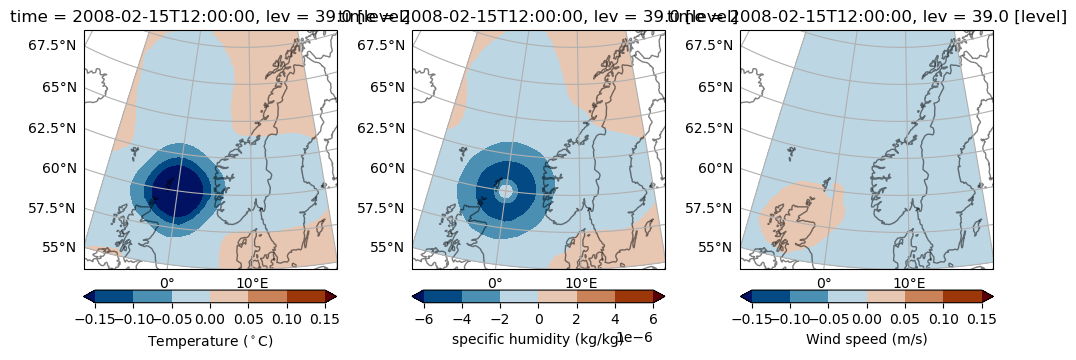

In [32]:
# plot difference surface
projection = cy.crs.EuroPP()
f, axsm = plt.subplots(1,3, subplot_kw={'projection':projection}, figsize=[10, 7.2])

for ax in axsm.flatten():
    # plot cosmetics
    ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
    ax.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False


(temp_background - temp_analysis).plot.contourf(ax=axsm[0], 
                                 x='lon', 
                                 y='lat', 
                                 cmap=cm.vik, 
                                 extend='both', 
                                 transform=cy.crs.PlateCarree(),
                                 levels=np.arange(-0.15,0.2,0.05),
                                 cbar_kwargs={'orientation':'horizontal','label':'Temperature ($^\circ$C)', 'shrink':1., 'pad':0.03})

(sh_background - sh_analysis).plot.contourf(ax=axsm[1], 
                                        x='lon',
                                        y='lat',
                                        cmap=cm.vik,
                                        extend='both',
                                        transform=cy.crs.PlateCarree(),
                                        cbar_kwargs={'orientation':'horizontal','label':'specific humidity (kg/kg)', 'shrink':1., 'pad':0.03}
                                        )

(ws_background - ws_analysis).plot.contourf(ax=axsm[2], 
                         x='lon', 
                         y='lat',
                         cmap=cm.vik,
                         extend='both',
                         transform=cy.crs.PlateCarree(),
                         levels=np.arange(-0.15,0.2,0.05),
                         cbar_kwargs={'orientation':'horizontal','label':'Wind speed (m/s)', 'shrink':1., 'pad':0.03}
                        )

plt.tight_layout()

Previously we found the maximum of the difference between background and analysis. We also see from the horizontal plot that the maximum difference between the analysis and the background is around 60𝑜
N and 0𝑜E (temperature).

In [23]:
# Set the latitude index according our finding that the maximum is at 60N. 
# seclat = _t.lat.where(_t.lat == _t.lat.isel(lat = _t.argmax(dim = ('lat', 'lon', 'lev'))['lat'],)).argmax()
seclat = int(_t.lat.isel(lat = _t.argmax(dim = ('lat', 'lon', 'lev'))['lat']))
seclat

60

In [24]:
timestep=0; 

tempvert_background =  model_background.air_temperature.isel(time = timestep,).sel( lat = seclat)
tempvert_analysis   =  model_analysis.air_temperature.isel(time = timestep,).sel( lat = seclat)

ws_vert_background = np.sqrt((model_background.x_wind.isel(time = timestep,).sel( lat = seclat))**2 + (model_background.y_wind.isel(time = timestep,).sel( lat = seclat))**2)
ws_vert_analysis = np.sqrt((model_analysis.x_wind.isel(time = timestep,).sel( lat = seclat))**2 + (model_analysis.y_wind.isel(time = timestep,).sel( lat = seclat))**2)

humidvert_background =  model_background.specific_humidity.isel(time = timestep,).sel( lat = seclat)
humidvert_analysis   =  model_analysis.specific_humidity.isel(time= timestep,).sel( lat = seclat)

In [25]:
# create difference between xB and xA
diff_tempvert = tempvert_background - tempvert_analysis
diff_ws_vert = ws_vert_background - ws_vert_analysis
diff_humidvert = humidvert_background - humidvert_analysis

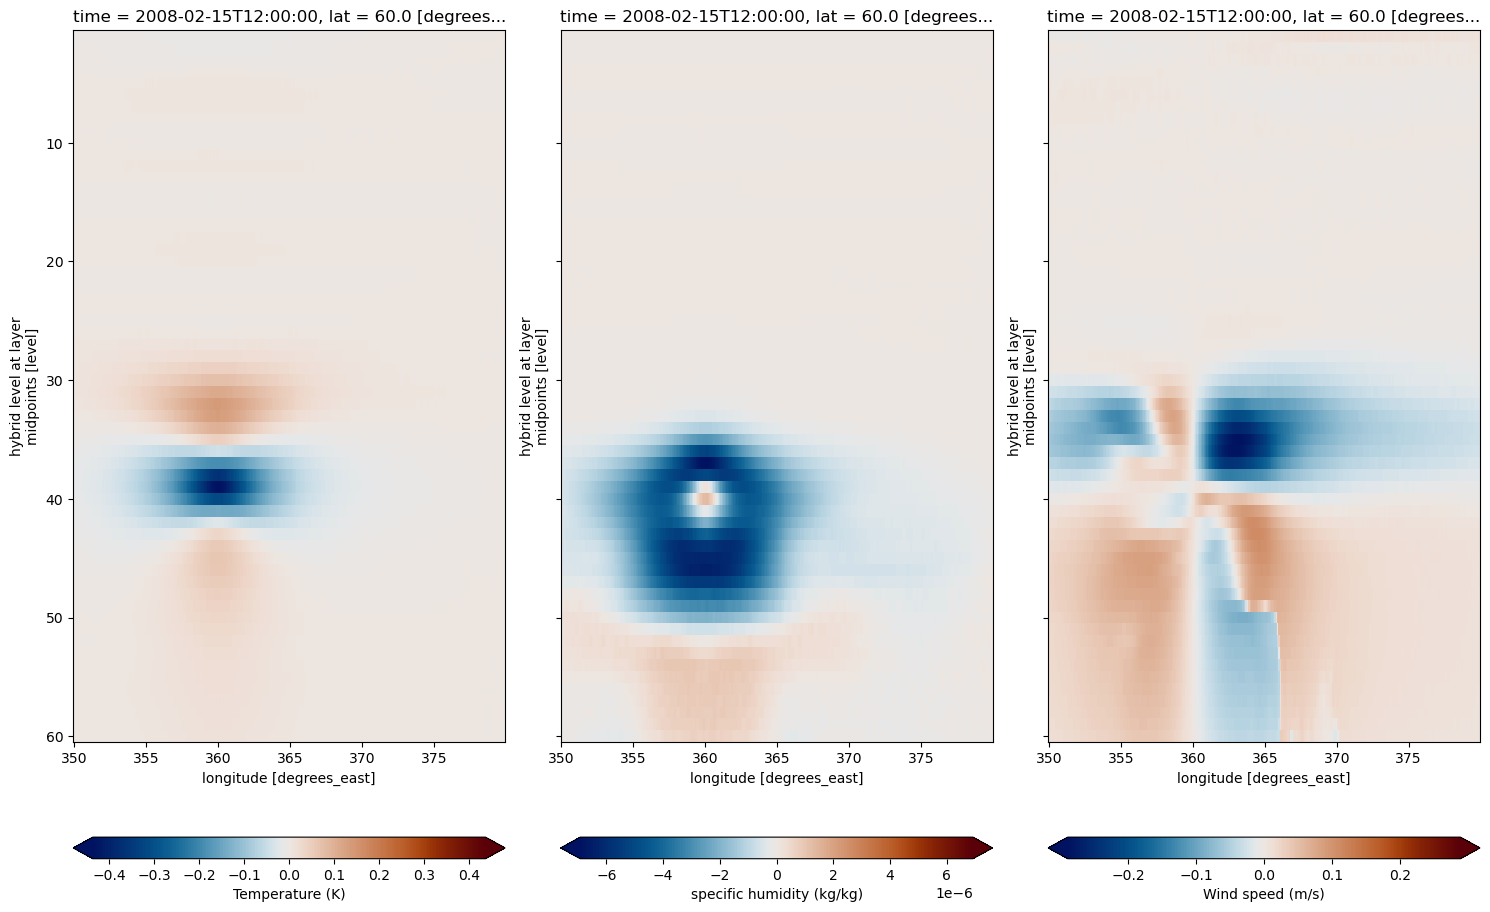

In [26]:
f, axsm = plt.subplots(1, 3, figsize = [15, 10], sharey=True, sharex=True)
axs = axsm.flatten()

# temperature
diff_tempvert.plot(ax=axsm[0], 
                         x='lon', 
                         y='lev', 
                         cmap=cm.vik, 
                         extend='both', 
                         cbar_kwargs={'orientation':'horizontal','label':'Temperature (K)', 'shrink':1, 'pad':0.1})

# humidity
diff_humidvert.plot(ax=axsm[1],
                    x='lon', 
                    y='lev', 
                    cmap=cm.vik, 
                    extend='both', 
                    cbar_kwargs={'orientation':'horizontal','label':'specific humidity (kg/kg)', 'shrink':1, 'pad':0.1})

# wind speed
diff_ws_vert.plot(ax=axsm[2],
                    x='lon', 
                    y='lev', 
                    cmap=cm.vik, 
                    extend='both', 
                    cbar_kwargs={'orientation':'horizontal','label':'Wind speed (m/s)', 'shrink':1, 'pad':0.1})

for ax in axsm.flatten():
    ax.invert_yaxis()
    
plt.tight_layout()

2. Estimate the spatial impact this one observation has.

* spatial impact = radius around radiosonde d = 5deg (as only 1 observation assimilated)
* vertical impact = ~5 levels

3. What is the impact on wind and humidity, and why&how could that be realized in the data assimilation system?

* both: smallest variations at release point, but largest closest to it ;)
* wind: more turbulences (noise)
* humidity: depending on temperature -> can be modified directly

